In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pickle
from glob import glob
import numpy as np
import cv2
import glob
from pathlib import Path
import matplotlib.pyplot as plt

from moviepy.editor import VideoFileClip
from IPython.display import HTML

import utils

In [37]:
from scipy.ndimage.measurements import label
from collections import deque

with open("./output_data/training_info.p", 'rb') as f:
    train_info = pickle.load(f)

svc = train_info["model"]
X_scaler = train_info["scaler"]
cspace = train_info["cspace"]
orient = train_info["orient"]
pix_per_cell = train_info["pix_per_cell"]
cell_per_block = train_info["cell_per_block"]
hog_channel = train_info["hog_channel"]
spatial_size = train_info["spatial_size"]
hist_bins = train_info["hist_bins"]


multi_scales = [
    (400, 500, 1.0),
    (400, 600, 1.2),
    (400, 600, 1.5),
    (400, 650, 1.7),
    (450, 650, 2.0),
    (450, 650, 2.3)    
]

threshold = 4
bbox_history = deque(maxlen=15)

def process_image(img):
    """
    """
    multiscale_bboxes = []
    for search_info in multi_scales:
        ## collect bbox
        ystart, ystop, scale = search_info
        bboxes = utils.find_cars(img, ystart, ystop, scale, svc, X_scaler, cspace, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
        multiscale_bboxes = multiscale_bboxes + bboxes
    ## draw bboxes
    bbox_history.appendleft(multiscale_bboxes)
    accum_bboxes = []
    for bbox in bbox_history:
        accum_bboxes.extend(bbox)
    img_bbox = utils.draw_boxes(img, accum_bboxes)

    ## make heatmatp
    img_heat = np.zeros_like(img[:,:,0]).astype(np.float)
    img_heat = utils.add_heat(img_heat, multiscale_bboxes)

    ## apply thresh
    img_thresh = utils.apply_threshold(np.copy(img_heat), threshold)
    labels = label(img_thresh)
    img_label, nlabel = labels

    ## draw labeled bbox
    img_label_bbox = utils.draw_labeled_bboxes(img, labels)
    w, h = (128*3, 72*3)
    img_label_bbox[:h,                : 1*w] = cv2.resize(img_bbox, (w, h))
    img_label_bbox[:h,     w+5   : 2*w+5] = cv2.cvtColor(255*cv2.resize(np.float32(utils.img_normalize(img_heat)), (w, h)),cv2.COLOR_GRAY2RGB)
    img_label_bbox[:h, 2*w+10 : 3*w+10] = cv2.cvtColor(255*cv2.resize(np.float32(utils.img_normalize(img_label)), (w, h)),cv2.COLOR_GRAY2RGB)
    return img_label_bbox

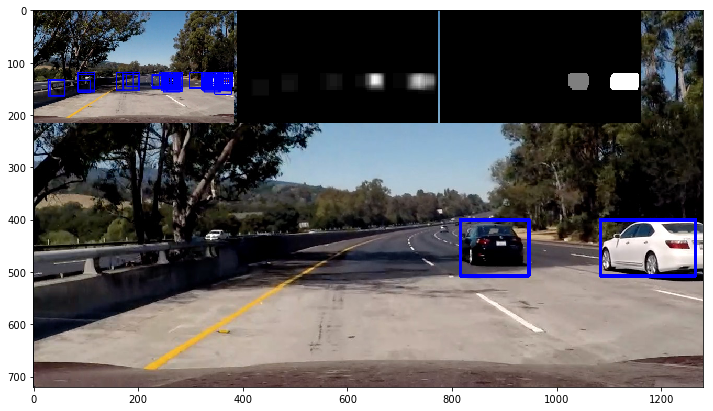

In [38]:
image_pathes = glob.glob("test_images/*jpg")

test_images = [utils.load_img(image_path) for image_path in image_pathes]

img = test_images[4]
plt.figure(figsize=(12, 12))
plt.imshow(process_image(img))

In [40]:
white_output = 'output_video/sol_project_video.mp4'

##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip = VideoFileClip("project_video.mp4").subclip(30, 45)
clip = VideoFileClip("project_video.mp4")
print(clip.fps)
#clip = clip.subclip(5, 15)#.set_fps(5)
white_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

25.0
[MoviePy] >>>> Building video output_video/sol_project_video.mp4
[MoviePy] Writing video output_video/sol_project_video.mp4



100%|█████████▉| 1260/1261 [1:21:00<00:03,  3.30s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/sol_project_video.mp4 

CPU times: user 3h 44min 25s, sys: 3min 39s, total: 3h 48min 5s
Wall time: 1h 21min 1s


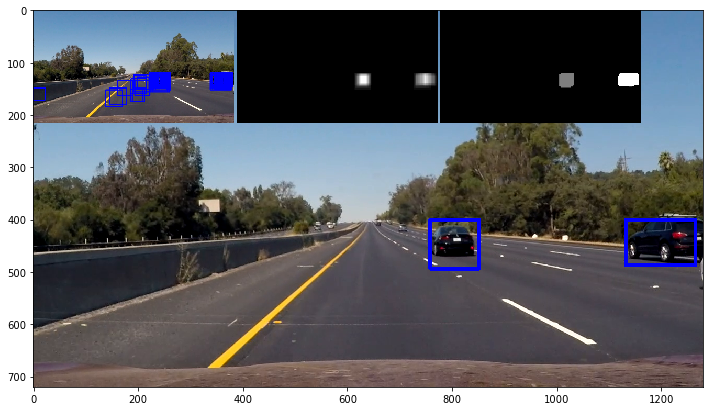

In [46]:
img = clip.get_frame(clip.end)
plt.figure(figsize=(12, 12))
plt.imshow(process_image(img))
plt.savefig("output_images/video_example.png", bbox_inches="tight")